# Setting up

In [1]:
# Python Stuff
import pandas as pd
import mpl_toolkits
import seaborn as sns 
from functools import reduce
import matplotlib.pyplot as plt

#PySpark stuff
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col, avg
from pyspark.sql.types import IntegerType, BooleanType, DateType, FloatType

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
  .builder \
  .master('yarn') \
  .appName('spark-bigquery-demo') \
  .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp-spark23_2.12:3.0.3")\
  .getOrCreate()

In [3]:
bucket = "big-data-yelp"
spark.conf.set('temporaryGcsBucket', bucket)

## Loading Business Basic

In [28]:
table = 'red-formula-339716:gfds.yelp_business_basicdata'
df_b = spark.read.format('bigquery').option('table', table).load()

In [5]:
df_b.show(3)

+-------------+--------------------+----------------+----------------+---------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+
|int64_field_0|         business_id|            name|         address|     city|state|postal_code|     latitude|      longitude|stars|review_count|is_open|          categories|
+-------------+--------------------+----------------+----------------+---------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+
|        10020|2tgAgCI8EJUA16EN4...|     Shaw Direct|W Georgia Street|Vancouver|   BC|       null|    49.285726|   -123.1231553|  2.0|           5|      1|Home Services, Pr...|
|        32306|wzwGYL2M4SvoLgTok...|Austin Tree Pros|            null|   Austin|   TX|       null|    30.267153|    -97.7430608|  2.0|           5|      1|Tree Services, La...|
|        37509|Tsk7LgyqWSwQSumLj...|   Pacific Grill|            null|Vancouver|   BC|       null|49.1981952989|-12

## Flitering Restaurants and Food & Cleaning

In [8]:
from pyspark.sql.functions import explode, split, col
df_b = df_b.withColumn('categories',(explode(split(col("categories"), ", "))))
df_b.groupby('categories').count().orderBy('count', ascending= 0).show(5, truncate = False)

+-------------+-----+
|categories   |count|
+-------------+-----+
|Restaurants  |50763|
|Food         |29469|
|Shopping     |26205|
|Beauty & Spas|16574|
|Home Services|16465|
+-------------+-----+
only showing top 5 rows



As we can see Restaurants have the highest amount among all business. Therefore, we decide to look into restaurants for our business use instead of whole business.

In [9]:
df_r = df_b.filter(df_b.categories.like("%Restaurants%"))

In [10]:
# Drop address and null values
df_r = df_r.drop('int64_field_0').drop('address')
df_r = df_r.na.drop(subset=["postal_code","categories"])

## Loading yelp_business_ambience

In [11]:
table_a = 'red-formula-339716:gfds.yelp_business_ambience'
df_a = spark.read.format('bigquery').option('table', table_a).load()

In [12]:
cols = ["casual", "classy", "divey", "hipster", "intimate", "romantic", "touristy", "trendy", "upscale"]
df_a = reduce(lambda df_a, c: df_a.withColumn(c, F.when(df_a[c] == 'false', 0).otherwise(1)), cols, df_a)

In [13]:
pda = df_a.toPandas()

## Loading business_attributes

In [14]:
table = 'red-formula-339716:gfds.yelp_business_attrbutes'
df_at = spark.read.format('bigquery').option('table', table).load()

## Loading business_businessparking

In [15]:
table = 'red-formula-339716:gfds.yelp_business_businessparking'
df_p = spark.read.format('bigquery').option('table', table).load()

## Loading Reviews

In [16]:
table_re = 'red-formula-339716:gfds.yelp_review'
df_re = spark.read.format('bigquery').option('table', table_re).load()

In [17]:
# change column stars to review_star
df_re= df_re.withColumnRenamed("stars","review_stars")

In [18]:
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.functions import month,year,hour
df_re = df_re.withColumn('compliment_count', col('cool') + col('funny') + col('useful')).drop('cool','funny','useful')
df_re = df_re.withColumn('date', to_timestamp(col('date'), "yyyy-MM-dd HH:mm:ss"))
df_re = df_re.withColumn('year', year(df_re['date']))
df_re = df_re.withColumn('month', month(df_re['date']))
df_re = df_re.withColumn('hour', month(df_re['date']))

## Loading Covid

In [19]:
table = 'red-formula-339716:gfds.yelp_covid'
df_c = spark.read.format('bigquery').option('table', table).load()
df_c.show(3)

+--------------------+----------+-------------------+---------------+----------------------+-----------------------+------------+----------------------+------------------------+
|         business_id|highlights|delivery_or_takeout|grubhub_enabled|call_to_action_enabled|request_a_quote_enabled|covid_banner|temporary_closed_until|virtual_services_offered|
+--------------------+----------+-------------------+---------------+----------------------+-----------------------+------------+----------------------+------------------------+
|9kXRUIkwdDtnAPO6t...|     FALSE|              false|          false|                 false|                  false|       FALSE|                 FALSE|                   FALSE|
|H6D5HOTfMjrZt7r1E...|     FALSE|              false|          false|                 false|                  false|       FALSE|                 FALSE|                   FALSE|
|FYddq7fUtzobZcw4j...|     FALSE|              false|          false|                 false|                  

In [20]:
df_c = df_c.na.drop(subset=["covid_banner"])

In [21]:
#Convert true and false to 1 and 0
import pyspark.sql.functions as F
from functools import reduce

cols = ["highlights", "delivery_or_takeout","grubhub_enabled","call_to_action_enabled","request_a_quote_enabled","covid_banner","temporary_closed_until","virtual_services_offered"]
df_c = reduce(lambda df_c, c: df_c.withColumn(c, F.when(df_c[c] == 'false', 0).otherwise(1)), cols, df_c)

## Loading Users table

In [22]:
table = 'red-formula-339716:gfds.yelp_user'
df = spark.read.format('bigquery').option('table', table).load()
df.show(3)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+-------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|   name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+-------+------------+------+--------------------+-------------------+
|         3.33|              0|              0|               0|

In [23]:
df_user = df.withColumn("yelping_since", to_timestamp("yelping_since", "yyyy-MM-dd hh:mm:ss"))

# EDA - Single Tables

## Business

In [23]:
# Getting the states with over 1000 resturants 
df_r = df_r.where((df_r.state == 'MA') | (df_r.state == 'OR') | (df_r.state == 'TX') | (df_r.state == 'FL') | (df_r.state == 'GA') | (df_r.state == 'BC') | (df_r.state == 'OH') |(df_r.state == 'CO') | (df_r.state == 'WA')) 
df_r.groupBy('state').count().orderBy('count', ascending  = 0).show(10)

+-----+-----+
|state|count|
+-----+-----+
|   MA|10550|
|   FL| 7705|
|   BC| 7497|
|   OR| 7387|
|   GA| 6139|
|   TX| 5440|
|   OH| 4377|
|   CO|  863|
|   WA|  773|
+-----+-----+



<AxesSubplot:xlabel='stars'>

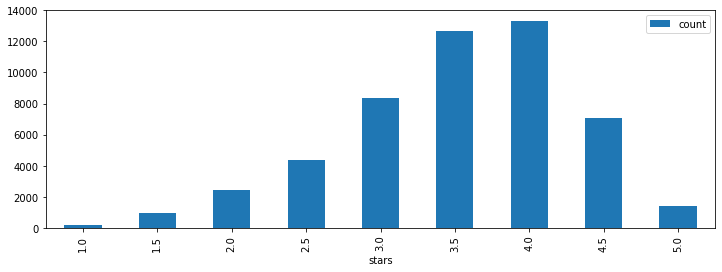

In [24]:
# Stars Distribution
#df_r.groupBy('stars').count().orderBy('count', ascending = 0).show()
pd_s = df_r.groupBy('stars').count().orderBy('stars', ascending = 1).toPandas()
pd_s.plot.bar(x = 'stars', y = 'count', figsize=(12,4))

In [25]:
# Show how many resturants is open
df_r.groupBy('is_open').count().orderBy('count').show()

+-------+-----+
|is_open|count|
+-------+-----+
|      0|18724|
|      1|32007|
+-------+-----+



## Business_ambience

In [26]:
# show the ambience of each business
pda.value_counts()

business_id             casual  classy  divey  hipster  intimate  romantic  touristy  trendy  upscale
--164t1nclzzmca7eDiJMw  0       0       0      1        0         0         0         0       0          1
eY3-ZE8-njGOglACqFYqVQ  1       1       0      0        0         0         0         0       0          1
eZcy-jmMJyYurpAi4xRVvA  1       0       0      0        0         0         0         0       0          1
eZcqcW1nWHroIdVLlswUtw  1       0       0      0        0         0         0         0       0          1
eZU5NF_tQfEtpE_ed7hoBA  1       0       0      0        0         0         0         0       0          1
                                                                                                        ..
K-5qxj6HIXbFd1fx-7r_xA  1       0       0      0        0         0         0         0       0          1
JzuiySs1YZON_71TqAWIKQ  1       0       0      0        0         0         0         1       0          1
JzlX-_eTIPEe2Ntytg1PPw  1       0       0 

In [27]:
df2 = df_r.select('business_id', 'name', 'stars').join(df_a, ['business_id'], "inner").drop('business_id', 'name')

In [28]:
# It shows the averge star of differernt ambience 
df2.groupBy('casual').agg(avg('stars')).show()
df2.groupBy('classy').agg(avg('stars')).show()
df2.groupBy('divey').agg(avg('stars')).show()
df2.groupBy('hipster').agg(avg('stars')).show()
df2.groupBy('intimate').agg(avg('stars')).show()
df2.groupBy('romantic').agg(avg('stars')).show()
df2.groupBy('touristy').agg(avg('stars')).show()
df2.groupBy('trendy').agg(avg('stars')).show()
df2.groupBy('upscale').agg(avg('stars')).show()

+------+------------------+
|casual|        avg(stars)|
+------+------------------+
|     1|3.6114103933497423|
|     0| 3.726584296532483|
+------+------------------+

+------+------------------+
|classy|        avg(stars)|
+------+------------------+
|     1|3.7942430703624734|
|     0|  3.58026019514636|
+------+------------------+

+-----+------------------+
|divey|        avg(stars)|
+-----+------------------+
|    1| 3.572354211663067|
|    0|3.6353756097560974|
+-----+------------------+

+-------+------------------+
|hipster|        avg(stars)|
+-------+------------------+
|      1|3.9585172109443953|
|      0|3.6186757416004407|
+-------+------------------+

+--------+------------------+
|intimate|        avg(stars)|
+--------+------------------+
|       1|3.9869831546707504|
|       0| 3.624256699359024|
+--------+------------------+

+--------+------------------+
|romantic|        avg(stars)|
+--------+------------------+
|       1| 3.865553602811951|
|       0|3.62808867677

In [29]:
df2pd = df2.toPandas()

In [30]:
df2pd

,stars,casual,classy,divey,hipster,intimate,romantic,touristy,trendy,upscale
0,2.0,1,0,0,0,0,0,0,0,0
1,2.0,1,0,0,0,0,0,0,0,0
2,2.0,0,0,0,0,0,0,0,1,0
3,2.0,1,0,0,0,0,0,0,0,0
4,2.0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
26546,1.5,1,0,0,0,0,0,0,0,0
26547,1.5,1,0,0,0,0,0,0,0,0
26548,1.5,1,0,0,1,0,0,0,0,0
26549,1.5,1,0,0,0,0,0,0,0,0


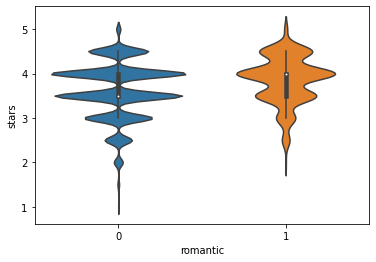

In [31]:
ax = sns.violinplot(x=df2pd["romantic"], y=df2pd["stars"])

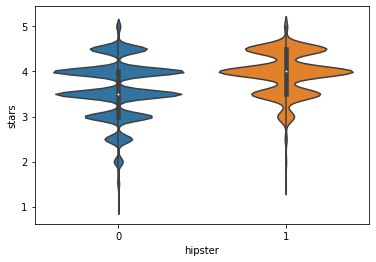

In [32]:
ax = sns.violinplot(x=df2pd["hipster"], y=df2pd["stars"])

classy, hipster, intimate, romantic, trendy, and upscale have very high  average stars. This could mean the ambience can affect restaurants' ratings

## Business_ambience

In [33]:
df3 = df_r.select('business_id', 'name', 'stars').join(df_at, ['business_id'], "inner").drop('business_id', 'name')

In [34]:
df3.groupBy('attributes_WiFi').agg(avg('stars')).show()
df3.groupBy('attributes_BikeParking').agg(avg('stars')).show()
df3.groupBy('attributes_RestaurantsGoodForGroups').agg(avg('stars')).show()
df3.groupBy('attributes_RestaurantsPriceRange2').agg(avg('stars')).show()
df3.groupBy('attributes_RestaurantsTakeOut').agg(avg('stars')).show()
df3.groupBy('attributes_NoiseLevel').agg(avg('stars')).show()
df3.groupBy('attributes_RestaurantsAttire').agg(avg('stars')).show()
df3.groupBy('attributes_GoodForKids').agg(avg('stars')).show()

+---------------+------------------+
|attributes_WiFi|        avg(stars)|
+---------------+------------------+
|          False|3.4043987799004656|
|           free|3.5890043737948547|
|           paid|3.2661870503597124|
|             no| 3.541118814248147|
+---------------+------------------+

+----------------------+-----------------+
|attributes_BikeParking|       avg(stars)|
+----------------------+-----------------+
|                  true|3.629050565706126|
|                 false|3.406063193851409|
+----------------------+-----------------+

+-----------------------------------+------------------+
|attributes_RestaurantsGoodForGroups|        avg(stars)|
+-----------------------------------+------------------+
|                               true|3.4884443824923332|
|                              false| 3.617017697328578|
+-----------------------------------+------------------+

+---------------------------------+------------------+
|attributes_RestaurantsPriceRange2|        avg

In [35]:
df3pd = df3.toPandas()
df3pd

22/03/12 03:31:49 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,stars,attributes_RestaurantsTableService,attributes_WiFi,attributes_BikeParking,attributes_BusinessAcceptsCreditCards,attributes_RestaurantsReservations,attributes_WheelchairAccessible,attributes_Caters,attributes_OutdoorSeating,attributes_RestaurantsGoodForGroups,...,attributes_GoodForDancing,attributes_BYOB,attributes_CoatCheck,attributes_Smoking,attributes_DriveThru,attributes_BYOBCorkage,attributes_Corkage,attributes_RestaurantsCounterService,attributes_AgesAllowed,attributes_Open24Hours
0,4.5,False,False,True,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4.5,False,no,True,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.5,False,free,True,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,3.5,False,free,True,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,4.0,False,free,True,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50726,3.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
50727,3.5,True,free,True,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
50728,3.5,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
50729,3.5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


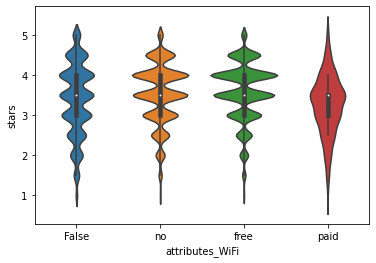

In [36]:
ax = sns.violinplot(x=df3pd["attributes_WiFi"], y=df3pd["stars"])

Looking at resturants attributes, we found out that some attributes is crutial and can have a big influence on the stars. For instance, restaurants which have free WIFI has a higher rating than others. resturants which is quient also has a very high ratings compared with others.

## Business_businessparking

In [37]:
df4 = df_r.select('business_id', 'name', 'stars').join(df_p, ['business_id'], "inner").drop('business_id', 'name')

In [38]:
for i in df4.columns:
    df4.groupBy(i).agg(avg('stars')).show()

+-----+----------+
|stars|avg(stars)|
+-----+----------+
|  3.5|       3.5|
|  4.5|       4.5|
|  2.5|       2.5|
|  1.0|       1.0|
|  4.0|       4.0|
|  3.0|       3.0|
|  2.0|       2.0|
|  1.5|       1.5|
|  5.0|       5.0|
+-----+----------+

+------+------------------+
|garage|        avg(stars)|
+------+------------------+
|  true|3.6095551894563425|
| false|3.5974381161346147|
+------+------------------+

+-----+------------------+
|  lot|        avg(stars)|
+-----+------------------+
| true|3.5207968901846454|
|false|3.7063926015930875|
+-----+------------------+

+------+-----------------+
|street|       avg(stars)|
+------+-----------------+
|  true| 3.75276988224375|
| false|3.451969154502892|
+------+-----------------+

+-----+------------------+
|valet|        avg(stars)|
+-----+------------------+
| true|3.6387264457439894|
|false|3.5966474671392703|
+-----+------------------+

+---------+-----------------+
|validated|       avg(stars)|
+---------+-----------------+
|   

In [39]:
df4pd = df4.toPandas()
df4pd

,stars,garage,lot,street,valet,validated
0,2.0,False,True,False,False,False
1,2.0,False,False,True,False,False
2,2.0,True,True,False,False,True
3,2.0,False,True,False,False,False
4,2.0,False,False,True,False,False
...,...,...,...,...,...,...
35389,1.5,False,False,True,False,False
35390,1.5,False,True,False,False,False
35391,1.5,False,True,False,False,False
35392,1.5,False,False,True,False,False


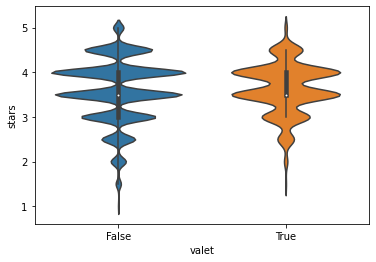

In [40]:
ax = sns.violinplot(x=df4pd["valet"], y=df4pd["stars"])

Interestingly, having a lot or having a valet has a negetice correlation in stars.However, if a restaurant have valet service, its stars are higher. This is maybe becasue restaurants which have valet are usually high-end.

## Users

In [41]:
# Users who have more than 1000 fans
df_user.filter(df.fans >= 1000).toPandas()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.91,962,12,962,413,18,39,309,715,570,...,11372,"2011,2012,2013",1308,"DfV7pgamJkE5DUsyD0yk1Q, 1_3wNEACntoy8o0XMQAQXg...",6778,Andy,1540,13712,IDVFG1pNSHIHoVuoLuZpcQ,2008-01-02 01:21:36
1,4.40,1018,13,1018,325,1,34,347,341,3173,...,17113,"2016,2017,2018,2019,20,20",2339,"5Jrl4Ye_bj6Tvwaba5hVLA, UYlpVLWL_vpzWu0RaIjyCw...",8473,Megan,950,21663,lt7bNHl-TXziny4FETu8nA,2015-06-18 04:19:47
2,4.37,673,13,673,298,3,26,430,266,2858,...,12959,"2014,2015,2016,2017,2018,2019,20,20",1360,"qMRqP6NsrSMu8xvEGC8Dsw, 9AntnfiqApb6OM8QZ7-IIg...",5739,Andi,989,17505,hdzTAN8DGJKRddkZ8279JQ,NaT
3,3.54,6304,135,6304,3125,224,370,3546,647,14702,...,19762,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...",1850,"iApZ4uEn_gG5yOGvWK0gjg, azupW8UYwIzcFGchoEz-Dg...",12245,Jando,4004,27187,ysCBsXWPB-LAiewVS3jZfQ,2006-11-08 07:31:36
4,3.86,1410,102,1410,864,89,90,1022,248,3380,...,10621,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...",1031,"k8fGyKKTQcMsVGR762YhKw, Ll_KV5XgfIuDxSRtcndCwA...",12544,Damien,1989,14766,rcU7ysY41qGppbw4pQgjqg,2007-06-30 00:28:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,4.11,968,1,968,383,1,54,511,880,1071,...,21952,"2018,2019,20,20",1369,"Xjvkq4MYfckpLYyPT0LcgA, 2XTxprGOFYWT7E5U4QUqCw...",9238,Sama,417,26288,8I7DLn7dPu76HQImdoqzQg,2015-12-07 03:49:34
69,3.77,24078,1414,24078,25304,429,2630,9622,45971,15336,...,103393,"2010,2011,2012,2013,2014,2015,2016,2017,2018,2...",3326,"sPk1JlWVFj1ZUiKABZSPdQ, TLnwWc0TS4N5t1vH60vueA...",96361,Cherylynn,2676,119725,eKUGKQRE-Ywi5dY55_zChg,2008-01-20 06:27:03
70,4.02,4522,721,4522,3841,251,318,2724,529,7573,...,24690,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...",1101,"GmcThitQOQF-8xo1nC03VQ, AwDQ4MDJEowPQaSfKx_xsw...",21354,Colleen,2775,33772,5MCBLBxr10NLUKZ4AboAMg,NaT
71,4.39,1381,17,1381,420,8,74,1397,380,6341,...,15551,"2013,2014,2015,2016,2017,2018,2019,20,20",1061,"icieSv0plXyXFHU15zYEQA, Dzuc8jWCQit4MoBMOrEpYQ...",5903,Michael,1044,20420,vHc-UrI9yfL_pnnc6nJtyQ,NaT


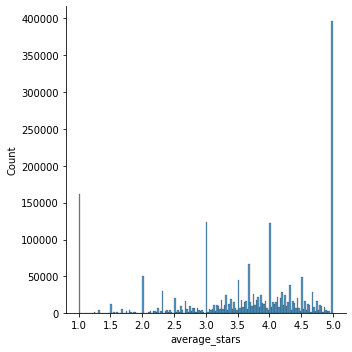

In [42]:
# show the bar graph of users given stars
dfp = df.select('average_stars').toPandas()
sns.displot(dfp, x="average_stars")

From the graph above, we can see two obvious bar which is 5.0 and 1.0. It means that a lot of users like to give extreme scores if they like/dislike a restaurant.

In [43]:
# users who give bad reviews
df_user.filter(df.average_stars <= 3).orderBy(["average_stars"], ascending=[1]).show(3)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+-------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|             friends|funny|   name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+--------------------+-----+-------+------------+------+--------------------+-------------------+
|          1.0|              0|              0|               0|

In [44]:
df_user = df_user.withColumn('year', year(df_user['yelping_since']))
df_user = df_user.withColumn('month', month(df_user['yelping_since']))

<AxesSubplot:xlabel='month'>

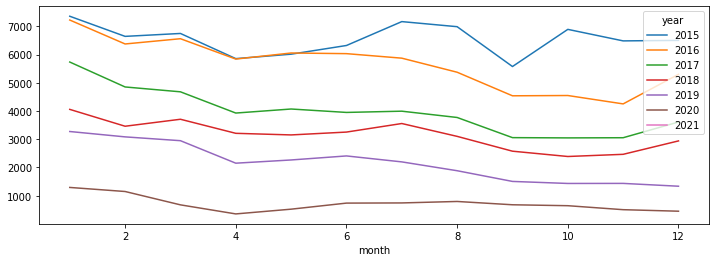

In [45]:
# monthly time series line chart of new users since 2015
df3c = df_user.filter(df_user.year >= 2015).groupBy('year', 'month').count().orderBy(["year", "month"], ascending=[0, 0])
pdf = df3c.toPandas()
pdf = pdf.pivot(index='month', columns='year', values='count')
pdf.plot(figsize=(12,4))


From the graph, we can see that the number of new users declinces each year. This is a potential business problem for Yelp. Yelp may need to develop strategy to attract more users.

## Covid

In [46]:
df_pdf = df_c.toPandas()

<AxesSubplot:title={'center':'virtual_services_offered'}>

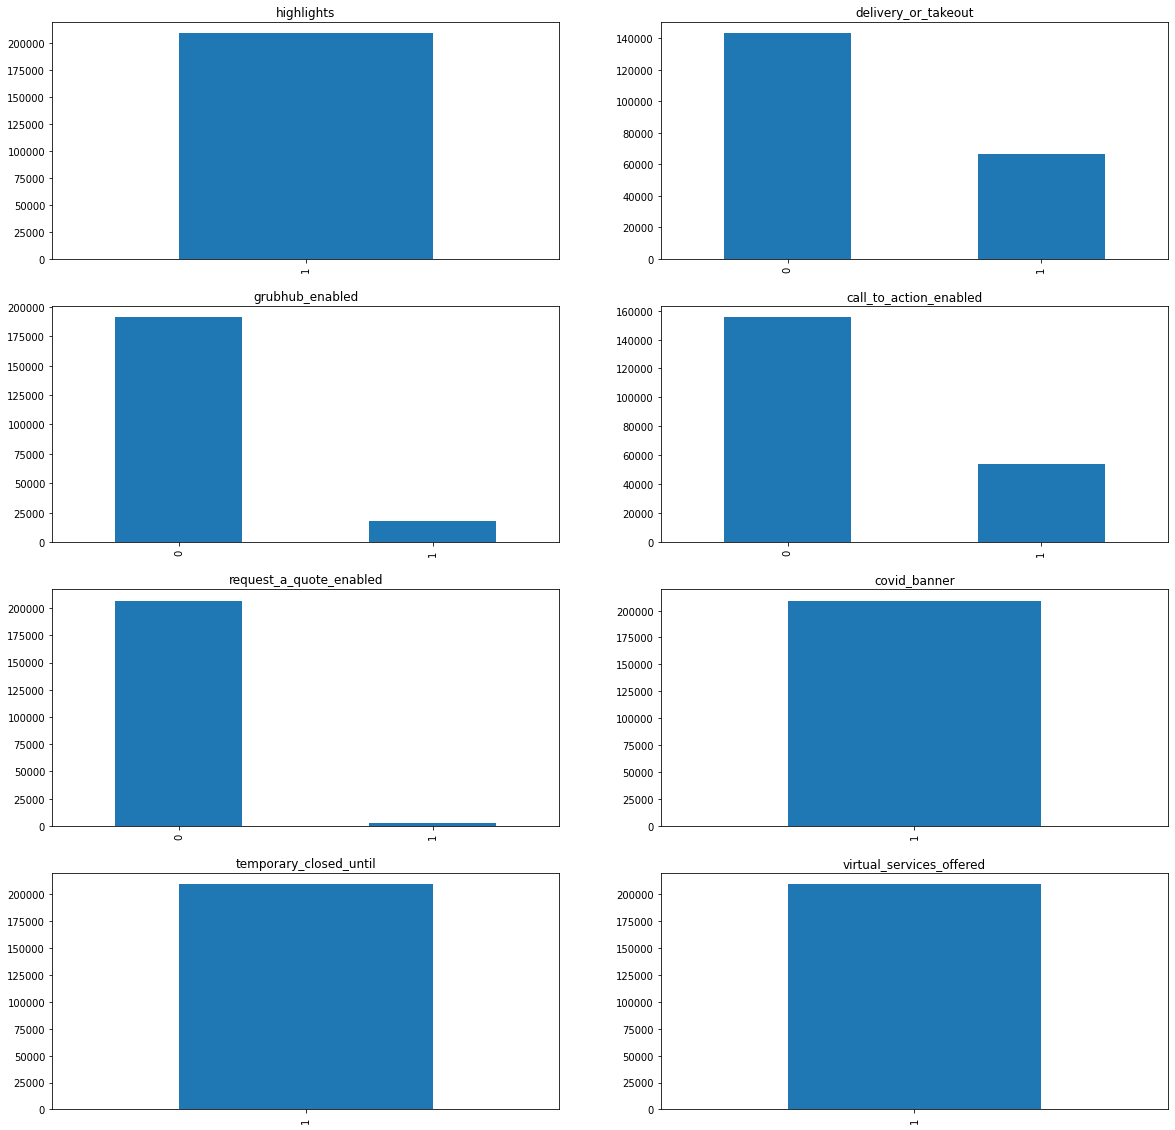

In [47]:
# Set up a grid of plots
fig = plt.figure(figsize=(20,20)) 
fig_dims = (4, 2)

# Plot accidents depending on type
plt.subplot2grid(fig_dims, (0, 0))
df_pdf['highlights'].value_counts().plot(kind='bar', 
                                     title='highlights')
plt.subplot2grid(fig_dims, (0, 1))
df_pdf['delivery_or_takeout'].value_counts().plot(kind='bar', 
                                     title='delivery_or_takeout')
plt.subplot2grid(fig_dims, (1, 0))
df_pdf['grubhub_enabled'].value_counts().plot(kind='bar', 
                                     title='grubhub_enabled')
plt.subplot2grid(fig_dims, (1, 1))
df_pdf['call_to_action_enabled'].value_counts().plot(kind='bar', 
                                     title='call_to_action_enabled')

plt.subplot2grid(fig_dims, (2, 0))
df_pdf['request_a_quote_enabled'].value_counts().plot(kind='bar', 
                                     title='request_a_quote_enabled')

plt.subplot2grid(fig_dims, (2, 1))
df_pdf['covid_banner'].value_counts().plot(kind='bar', 
                                     title='covid_banner')

plt.subplot2grid(fig_dims, (3, 0))
df_pdf['temporary_closed_until'].value_counts().plot(kind='bar', 
                                     title='temporary_closed_until')

plt.subplot2grid(fig_dims, (3, 1))
df_pdf['virtual_services_offered'].value_counts().plot(kind='bar', 
                                     title='virtual_services_offered')


Looks pretty imbalanced, more balance in delivery_or_takeout and call_to_action_enabled and some '1's in grubhub_enabled and highlights. Can drop temporary_closed_until, request_a_quote_enabled and virtual_services_offered as they are mostly 0.

<AxesSubplot:xlabel='delivery_or_takeout', ylabel='count'>

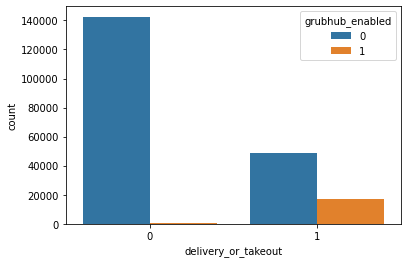

In [48]:
sns.countplot(x="delivery_or_takeout", hue="grubhub_enabled", data=df_pdf)

High correlation between delivery_or_takeout and grubhub_enabled: when there is no delivery_or_takeout option, there is barely any grubhub_enabled. On the contray, when there is delivery_or_takeout, there are some grubhub_enabled, with the business perhaps using other delivery apps as well.

In [49]:
from pyspark.ml import stat
df_c.stat.corr("delivery_or_takeout","grubhub_enabled")

0.4290360525801788

<AxesSubplot:xlabel='call_to_action_enabled', ylabel='count'>

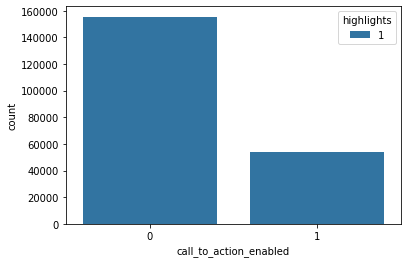

In [50]:
sns.countplot(x="call_to_action_enabled", hue="highlights", data=df_pdf)

Some correlation between highlights and call_to_action_enabled: If highlight (highlights during Covid such as curbside pick up present, drive thru present, etc) present, typically a CTA button is also present.

## Reviews

<AxesSubplot:xlabel='year'>

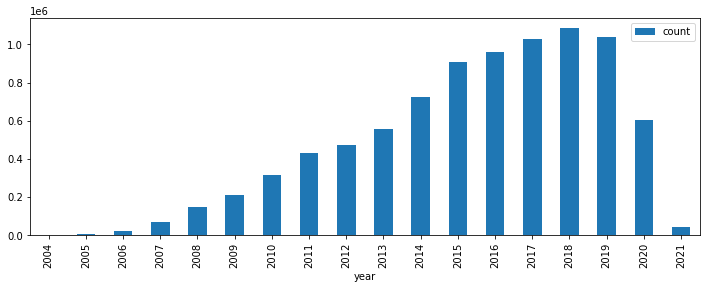

In [51]:
#Number of reviews per year, dramatic decrease in 2020
pd_y = df_re.groupBy('year').count().orderBy('year', ascending = 1).toPandas()
pd_y.plot.bar(x = 'year', y = 'count', figsize=(12,4))

<AxesSubplot:xlabel='review_stars'>

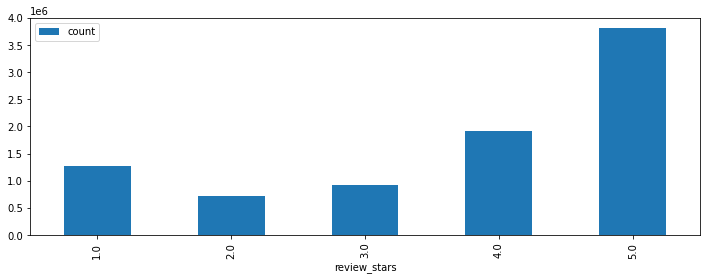

In [52]:
# Number of star reviews
pd_st = df_re.groupBy('review_stars').count().orderBy('review_stars', ascending = 1).toPandas()
pd_st.plot.bar(x = 'review_stars', y = 'count', figsize=(12,4))


<AxesSubplot:xlabel='hour'>

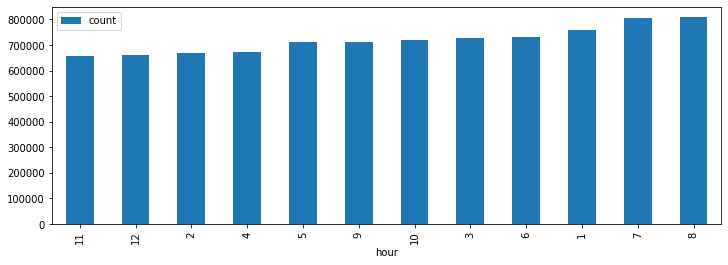

In [53]:
# what time of the day do people usually leave reviews
df_hour = df_re.groupby('hour').count().orderBy('count')
df_hour.toPandas().plot.bar(x = 'hour', y = 'count', figsize=(12,4))

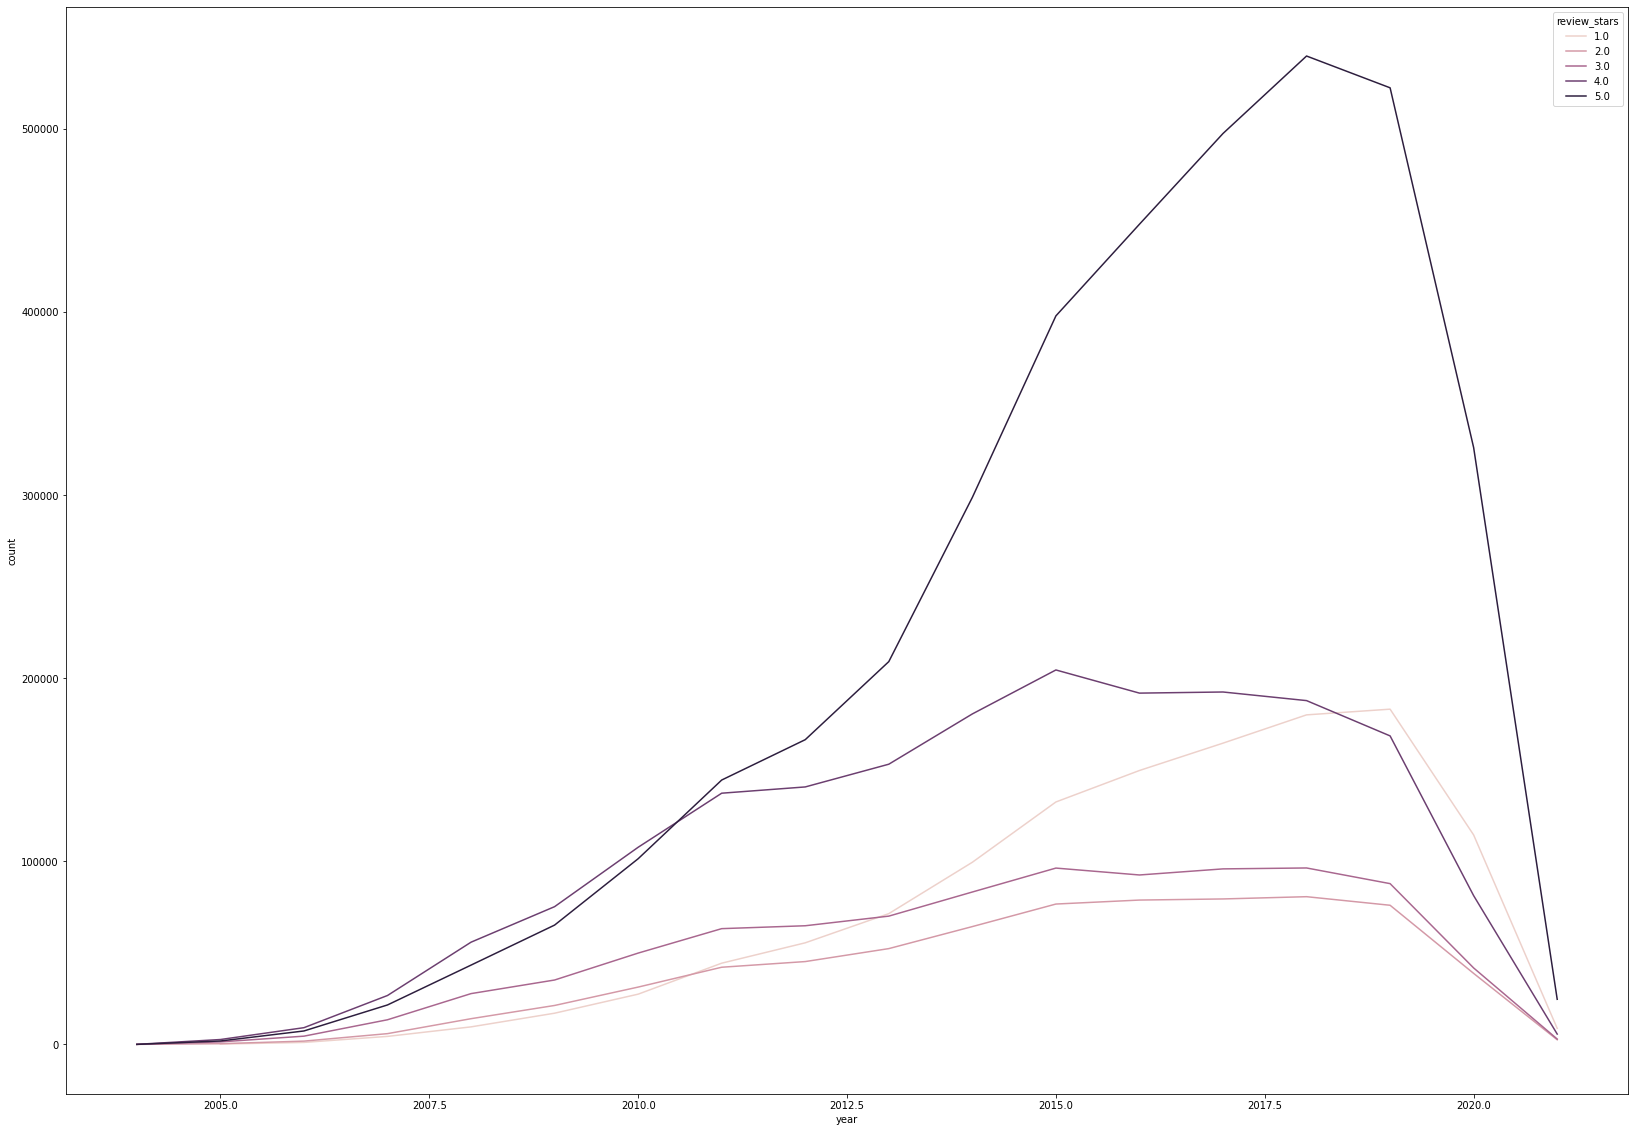

In [54]:
## Each year change of  1-5 stars count 
df_star_change = df_re.groupBy('year','review_stars').count().orderBy('year','review_stars',ascending = 0).toPandas()
fig2, ax2 = plt.subplots(figsize=(28,20))
#ax3=ax1.twinx()

#sns.barplot(x='year', y='count', data=df_crime, hue='primary_type',ax=ax3)
sns.lineplot(x='year', y='count', data=df_star_change, hue='review_stars',ax=ax2)
plt.show()

# Comprehensive EDA

### Figure out where is the user


In [56]:
# Figure out where is the user

review_business_user_city = df_re.select('business_id', 'user_id')
business_city = df_r.select('business_id', 'city')

user_city_spark = review_business_user_city.join(business_city, ["business_id"], 'left')
user_city_df = user_city_spark.groupby('user_id', 'city').count().toPandas()
user_city_group = user_city_df.groupby(['user_id', 'city'])
user_city = 100 * user_city_group.sum() / user_city_df[['user_id', 'count']].groupby('user_id').sum()
user_city.reset_index(inplace = True)

Threshold = 70
user_city['local'] = user_city['count'].apply(lambda x: True if x >= Threshold else False)

user_city.head()

,user_id,city,count,local
0,---2PmXbF47D870stH1jqA,Smyrna,33.333333,False
1,---7FS-3SMy-cnnIPHcW9w,Boston,100.000000,True
2,---fQxo-9tYZAkyWYrSfdA,Lake Mary,100.000000,True
3,---r2Fuca3t1PT3oalARQQ,Austin,100.000000,True
4,---sEqd6eCGsnr8nOXrkDw,Orlando,100.000000,True


In [57]:
user_richmond = user_city[user_city["city"].str.contains("richmond", case = False)]
user_richmond.head(10)


,user_id,city,count,local
199,--JxzhxSwOjTXmnaWU_7DQ,Richmond,100.000000,True
220,--N3a9oKp38UlsOswdLx1Q,Richmond,75.000000,True
260,--SX97LkvytDEKL7GeJ87Q,Richmond,20.000000,False
264,--T4AaKXe3q98YJPP5gcTQ,Richmond,14.285714,False
314,--Z3D9wpKcTQ9NxCKWWQtA,Richmond,100.000000,True
814,-0O2d7C1KFutGQmdCtJmYA,Richmond,9.638554,False
1325,-1EVwBXVsw2lbc66GRuVtQ,Richmond,16.666667,False
1336,-1Ggrhh5GVEYARP1eA817g,Richmond,100.000000,True
1390,-1M3sFN4ZOCR59-mYJr65A,Richmond,17.391304,False
1464,-1Wj5JcUctnODWRyaIA9Ag,Richmond,100.000000,True


### Which City has most reviews for resturants?

In [70]:
# change df_r to df_r_oh
review_business = df_re.join(df_r_oh, ["business_id"], 'inner')
review_business_pd = review_business.groupby('city').count().toPandas()

In [71]:
review_business_pd = review_business_pd.sort_values('count',ascending=False)
review_business_pd = review_business_pd.iloc[:10]

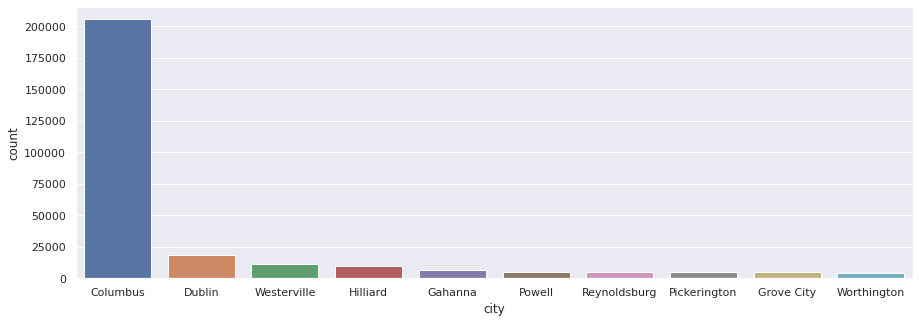

In [72]:
ax = sns.barplot(x="city", y="count", data=review_business_pd)

## Top 10 Restaurant with most Five Star Reviews from Users


Text(0, 0.5, 'Top 10 Popular Restaurants')

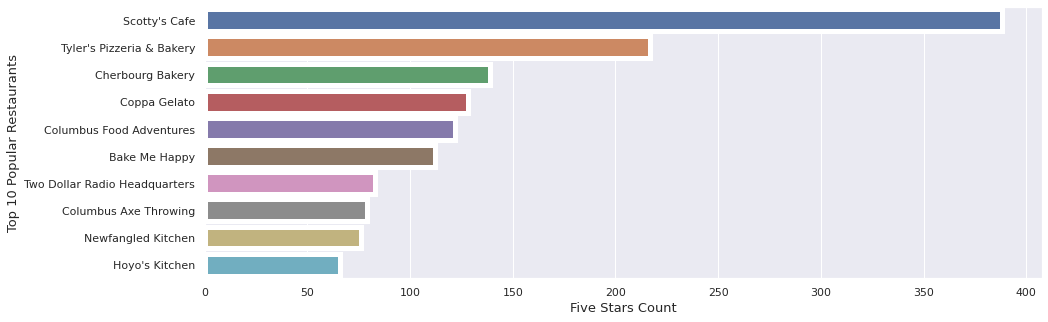

In [73]:
most_five_star = review_business.filter(review_business.stars == 5)
most_five_star_ = most_five_star.groupby('name').count().orderBy('count',ascending = 0).toPandas().iloc[0:10]
p= sns.barplot(x="count",y="name", data=most_five_star_, linewidth=5)
p.set_xlabel("Five Stars Count", fontsize = 13)
p.set_ylabel("Top 10 Popular Restaurants", fontsize = 13)


## top 100 users in Ohio who made most reviews and count citys they visited

In [74]:
top_100 = review_business.groupby('user_id').agg(F.count(review_business.review_id),F.countDistinct(review_business.city)).orderBy('count(review_id)',ascending = 0).limit(100).show(truncate=False)


+----------------------+----------------+-----------+
|user_id               |count(review_id)|count(city)|
+----------------------+----------------+-----------+
|C1kTSvNdJH_S2bBhitr6ZA|917             |20         |
|R1FVpAyl_BtxHBWdau2VLg|890             |29         |
|JzP5uJjhZb0Vj8J_bn3mOg|748             |27         |
|tgeFUChlh7v8bZFVl2-hjQ|625             |26         |
|wZ0KFPTp1263hDl2M0gXGg|463             |15         |
|VatcQtdb5tlz4D-N6y8e7A|411             |19         |
|c0uIYXfInsCHPZEovnSLYw|409             |13         |
|fNzgaewYge8DK2qtTPZzog|400             |25         |
|ZVtccj29aF_JEy92KOyEqg|351             |17         |
|wSByVbwME4MzgkJaFyfvNg|350             |17         |
|nmdkHL2JKFx55T3nq5VziA|319             |20         |
|PeIFSmI0I1ILYjUjjUSZdA|315             |17         |
|9leRUv4_XFUuGyevKJKA-Q|311             |15         |
|J72tTd5cnQ4EvtYToewELA|311             |11         |
|TJMgOTcm2ShyOpablSYbXA|303             |19         |
|1Iv3fyJSC5qk1zpzhPUdWA|302 

### Reviews by State

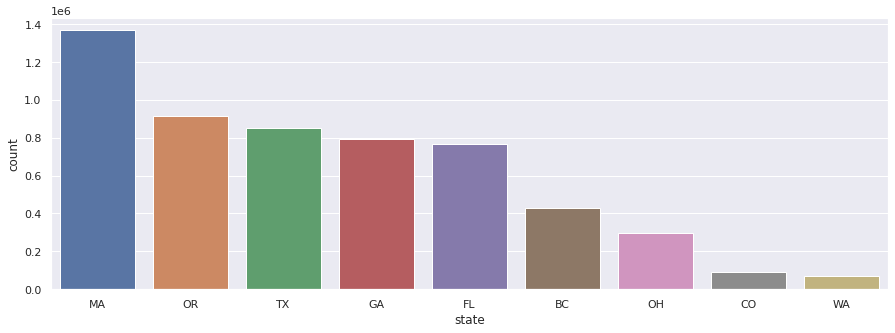

In [77]:
review_business = df_re.join(df_r, ["business_id"], 'inner')
review_business_state = review_business.groupby('state').count().toPandas()
review_business_state = review_business_state.sort_values('count',ascending=False)
review_business_state = review_business_state.iloc[:10]
ax = sns.barplot(x="state", y="count", data=review_business_state)

In [64]:
df_r_oh = df_r.filter(df_r.state=='OH')

In [65]:
df_r_oh_pd =  df_r_oh.toPandas()
df_r_oh_2 = df_r_oh_pd.sort_values('stars',ascending=False)[:10]
df_r_oh_2

,business_id,name,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
4133,Q-xb6mzQYiJ8ujaMhCeSyQ,Tacomania,columbus,OH,43035,40.069121,-83.094131,5.0,8,1,"Tacos, Burgers, Mexican, Restaurants, Food Tru..."
4156,rTqQvMbianytSBc4h3sRQw,Los Agavez Taqueria,Columbus,OH,43202,40.026783,-83.013703,5.0,62,1,"Street Vendors, Mexican, Food, Food Trucks, Re..."
4146,SRcVzDKPsqlwNSy68pssxA,Mo's Place,Commercial Point,OH,43116,39.768564,-83.057583,5.0,6,1,"Sandwiches, Pizza, Restaurants"
4147,9D-hh7wWwGGA-qDDche19Q,Gary's Hole In One,Grove City,OH,43123,39.877398,-83.055309,5.0,5,1,"Lounges, Bars, Nightlife, Chinese, Restaurants"
4148,UKMiC9K7vJF5stMaJXrN6g,Tony's Bar & Grille,London,OH,43140,39.900468,-83.434476,5.0,6,1,"Burgers, Chicken Wings, Restaurants, American ..."
4149,_hvHNH2DskVyN7zr6bGqIw,"R Cafe née ""Red Velvet Cafe Pickerington""",Pickerington,OH,43147,39.912065,-82.778893,5.0,51,0,"Sandwiches, Cupcakes, Empanadas, Food, Restaur..."
4150,-AIj0yS_K7tnCKOtKnbzWw,Squeek's Bar and Grill,Pickerington,OH,43147,39.911563,-82.778446,5.0,6,1,"Nightlife, American (Traditional), Arts & Ente..."
4152,4cNxeCSjPi9zP-UJvK1IfQ,Dan's Deli No 44,Columbus,OH,43201,39.993820,-83.006469,5.0,6,1,"Street Vendors, Food, Delis, Restaurants"
4153,zMLfeOoVUSjv6xqddv2kdA,Crazy Corky's Café,Columbus,OH,43201,40.004470,-83.008242,5.0,5,0,"Cafes, Food, American (New), Sandwiches, Resta..."
4154,6rFfI22GfWYQb1SO0AP7iA,Outsliders at Little Rock,Columbus,OH,43201,39.982242,-82.998442,5.0,5,1,"Bars, Restaurants, Nightlife, American (New), ..."


In [66]:
df_r_oh_2 = df_r_oh_2.drop(['postal_code','latitude','longitude','is_open'],axis=1)

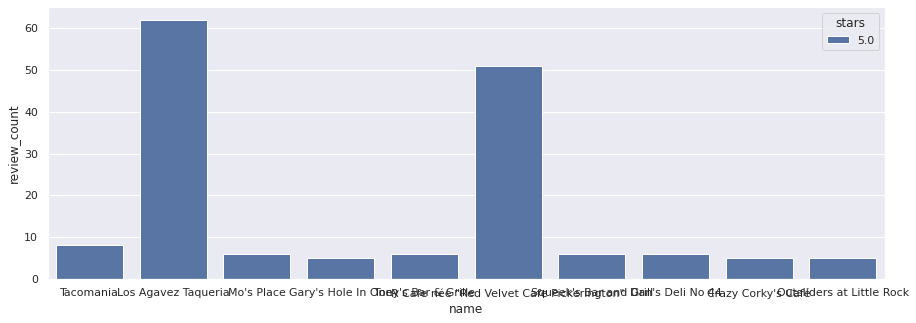

In [67]:
#Top rating Resturants In ohio
sns.set(rc={'figure.figsize':(15,5)})
ax = sns.barplot(x="name", y="review_count", hue="stars", data=df_r_oh_2)


In [105]:
df_r_oh_3 = df_r_oh_pd.sample(n = 8)

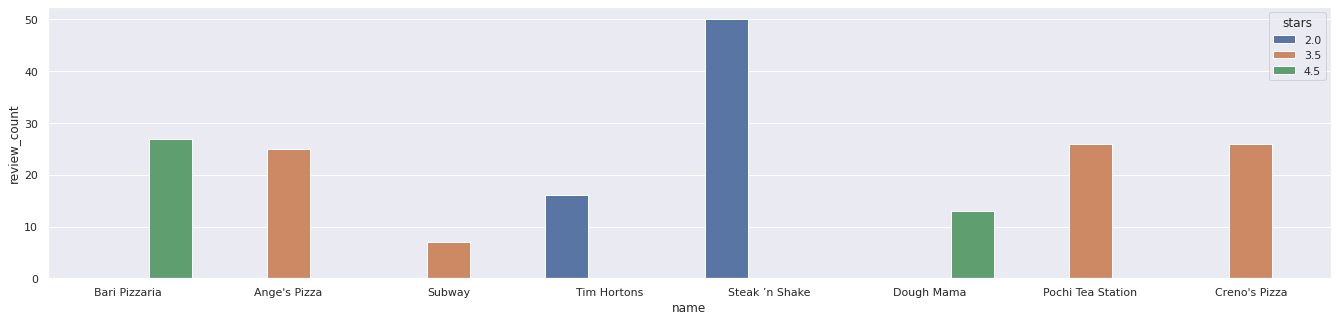

In [106]:
#5 random  Resturants In ohio
sns.set(rc={'figure.figsize':(23,5)})
ax = sns.barplot(x="name", y="review_count", hue="stars", data=df_r_oh_3)

In [30]:
df_restaurant = df_b.where(df_b.categories.like('%Restaurant%') | (df_b.state == 'OH')).select('name', 'stars', 'review_count')

In [31]:
pd_restaurant = df_restaurant.toPandas()

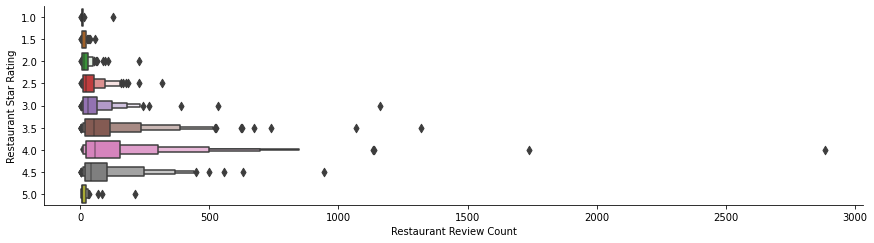

In [32]:
ax = sns.catplot(x="review_count", y="stars", orient="h", kind="boxen", data = pd_restaurant.sample(n = 1000, random_state = 6), height=3.5, aspect=3.5)
ax.set_axis_labels("Restaurant Review Count", "Restaurant Star Rating")